# Comparative Analysis of Classification Algorithms for Predicting Customer Churn in the Telecom Industry

## Imports and Data loading

In [60]:
# Import  libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Loading dataset
df = pd.read_excel('Telco_customer_churn.xlsx')

# Display
print("Dataset shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
df.head()

Dataset shape: (7043, 33)

First 5 rows of the dataset:


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## Data Description

In [61]:
# Basic dataset information
print("Basic information about the dataset:")
df.info()

Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   

In [62]:
# Summary statistics
print("\nSummary statistics:")
df.describe()


Summary statistics:


,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


In [63]:
# Check for missing values
print("Missing values in each column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.any() > 0 else "No missing values found")

Missing values in each column:
Churn Reason    5174
dtype: int64


In [64]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


## Data Cleaning

In [65]:
# 1. Convert 'Total Charges' from object to numeric type
# First check for non-numeric values
non_numeric = pd.to_numeric(df['Total Charges'], errors='coerce').isna()
print(f"Number of non-numeric values in 'Total Charges': {non_numeric.sum()}")

# Convert 'Total Charges' to numeric
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

# Fill missing values in 'Total Charges' (if any)
if df['Total Charges'].isna().any():
    # For customers with 0 tenure, Total Charges should be 0
    df.loc[df['Tenure Months'] == 0, 'Total Charges'] = 0

    # For others, use the product of Monthly Charges and Tenure Months
    mask = (df['Total Charges'].isna()) & (df['Tenure Months'] > 0)
    df.loc[mask, 'Total Charges'] = df.loc[mask, 'Monthly Charges'] * df.loc[mask, 'Tenure Months']

Number of non-numeric values in 'Total Charges': 11


In [66]:
# 2. Handle missing values in 'Churn Reason'
# Since Churn Reason is only relevant for churned customers, we can keep it as is
# Or we can fill with 'Not Applicable' for non-churned customers
df.loc[df['Churn Label'] == 'No', 'Churn Reason'] = 'Not Applicable'

In [67]:
# 3. Standardize binary categorical variables
df['Churn Value'] = df['Churn Label'].map({'Yes': 1, 'No': 0})

In [68]:
# 4. Check for outliers in numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [69]:
# Function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers.count()

# Check for outliers in numeric columns
print("\nNumber of outliers in each numeric column:")
for col in numeric_cols:
    num_outliers = detect_outliers(df, col)
    if num_outliers > 0:
        print(f"{col}: {num_outliers} outliers")
    else:
      print(f"{col}: No outliers")


Number of outliers in each numeric column:
Count: No outliers
Zip Code: No outliers
Latitude: No outliers
Longitude: No outliers
Tenure Months: No outliers
Monthly Charges: No outliers
Total Charges: No outliers
Churn Value: No outliers
Churn Score: No outliers
CLTV: No outliers


## Exploratory Data Analysis

### Demographic Analysis

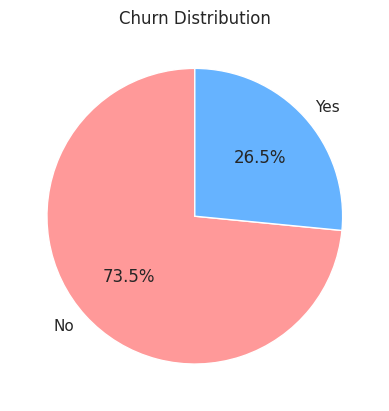

In [70]:
# Set up the visualization environment
plt.style.use('ggplot')
sns.set(style="whitegrid")

# 1. Churn Distribution - Pie Chart
labels = df['Churn Label'].value_counts().index
sizes = df['Churn Label'].value_counts().values
colors = ['#ff9999','#66b3ff']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Churn Distribution')
plt.show()

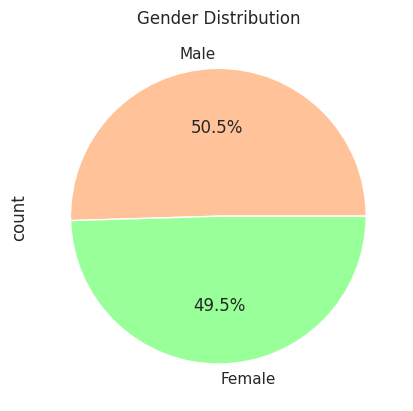

In [71]:
# 2. Gender Distribution
df['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#ffc299', '#99ff99'])
plt.title('Gender Distribution')
plt.show()


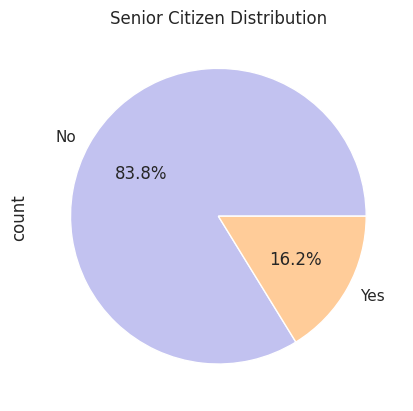

In [72]:
# 3. Senior Citizen Distribution
df['Senior Citizen'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#c2c2f0', '#ffcc99'])
plt.title('Senior Citizen Distribution')
plt.show()

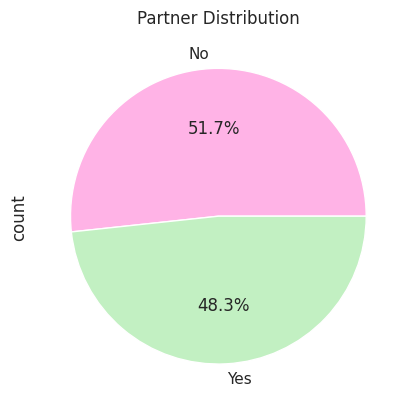

In [73]:
# 4. Partner Distribution
df['Partner'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#ffb3e6', '#c2f0c2'])
plt.title('Partner Distribution')
plt.show()

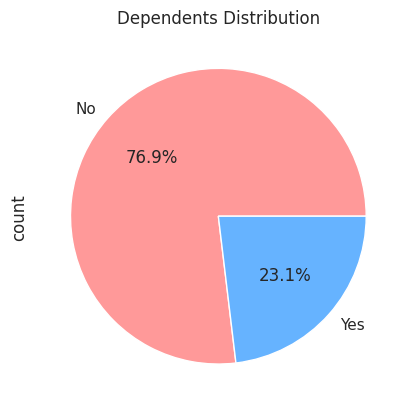

In [74]:
# 5. Dependents Distribution
df['Dependents'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Dependents Distribution')
plt.show()

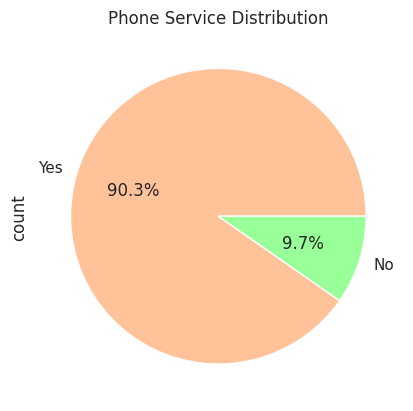

In [75]:
# 6. Phone Service Distribution
df['Phone Service'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#ffc299', '#99ff99'])
plt.title('Phone Service Distribution')
plt.show()

### Churn Relationship

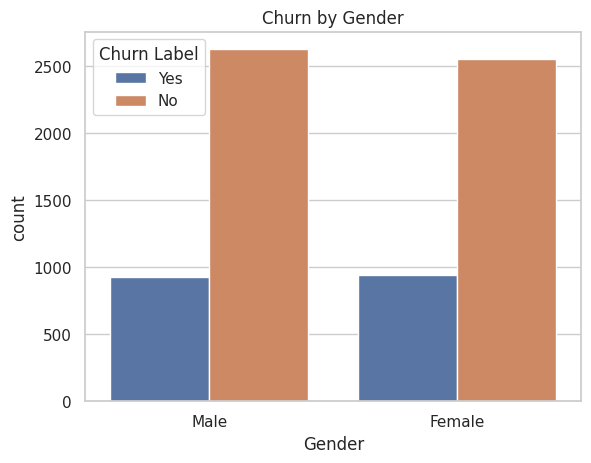

In [76]:
# 7. Churn by Gender
sns.countplot(x='Gender', hue='Churn Label', data=df)
plt.title('Churn by Gender')
plt.show()

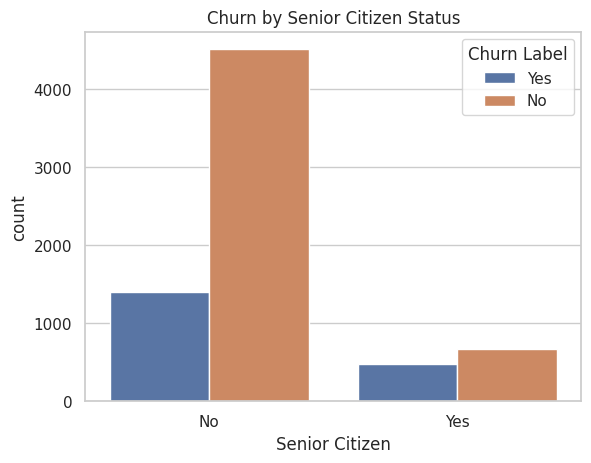

In [77]:
# 8. Churn by Senior Citizen
sns.countplot(x='Senior Citizen', hue='Churn Label', data=df)
plt.title('Churn by Senior Citizen Status')
plt.show()

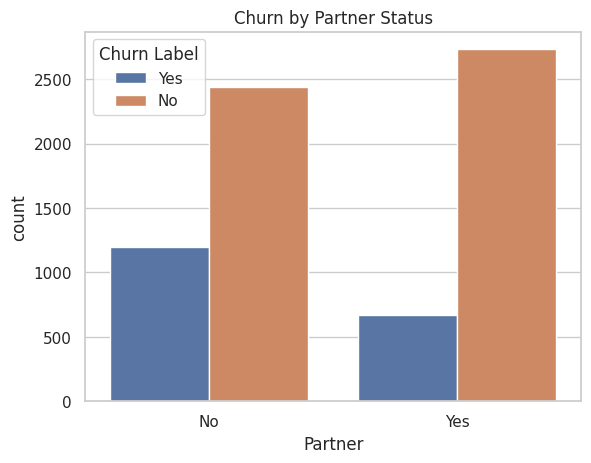

In [78]:
# 9. Churn by Partner
sns.countplot(x='Partner', hue='Churn Label', data=df)
plt.title('Churn by Partner Status')
plt.show()

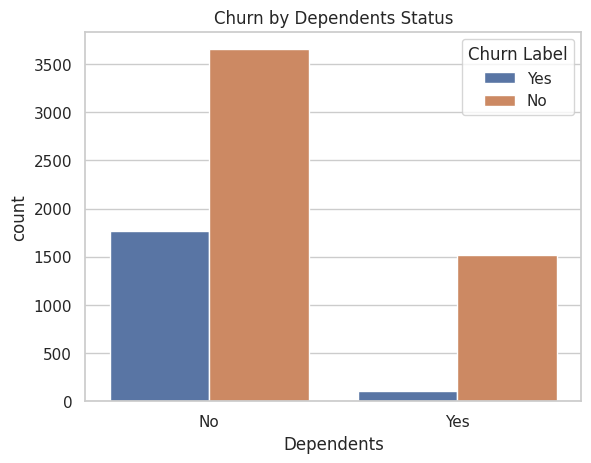

In [79]:
# 10. Churn by Dependents
sns.countplot(x='Dependents', hue='Churn Label', data=df)
plt.title('Churn by Dependents Status')
plt.show()

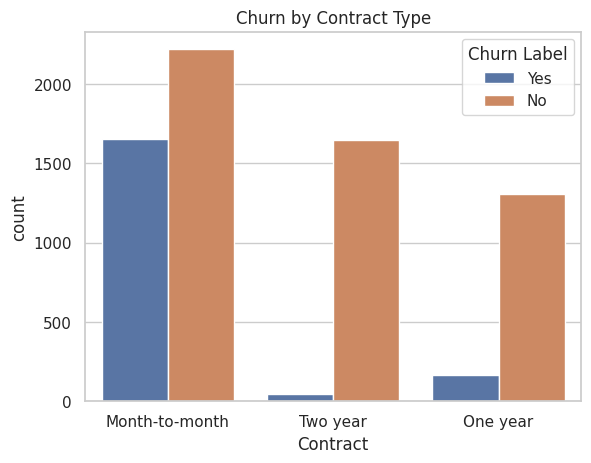

In [80]:
# 11. Churn by Contract Type
sns.countplot(x='Contract', hue='Churn Label', data=df)
plt.title('Churn by Contract Type')
plt.show()

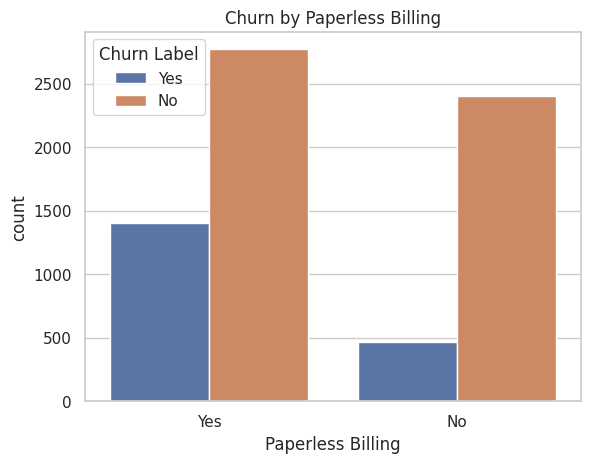

In [81]:
# 12. Churn by Paperless Billing
sns.countplot(x='Paperless Billing', hue='Churn Label', data=df)
plt.title('Churn by Paperless Billing')
plt.show()

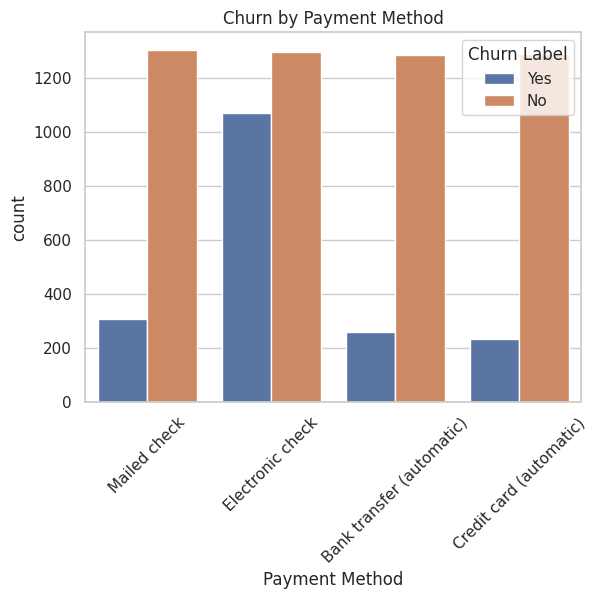

In [82]:
# 13. Churn by Payment Method
plt.xticks(rotation=45)
sns.countplot(x='Payment Method', hue='Churn Label', data=df)
plt.title('Churn by Payment Method')
plt.show()

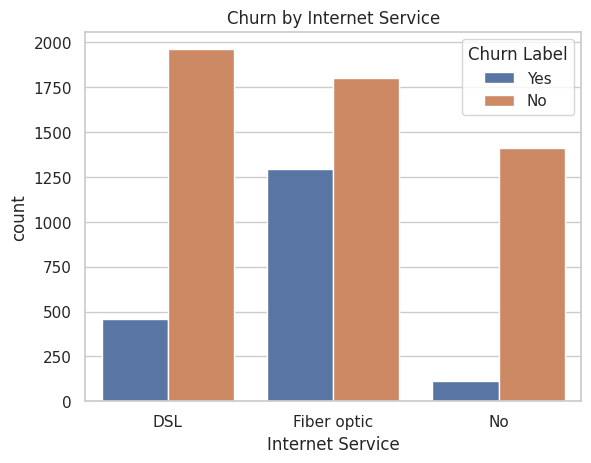

In [83]:
# 14. Churn by Internet Service
sns.countplot(x='Internet Service', hue='Churn Label', data=df)
plt.title('Churn by Internet Service')
plt.show()

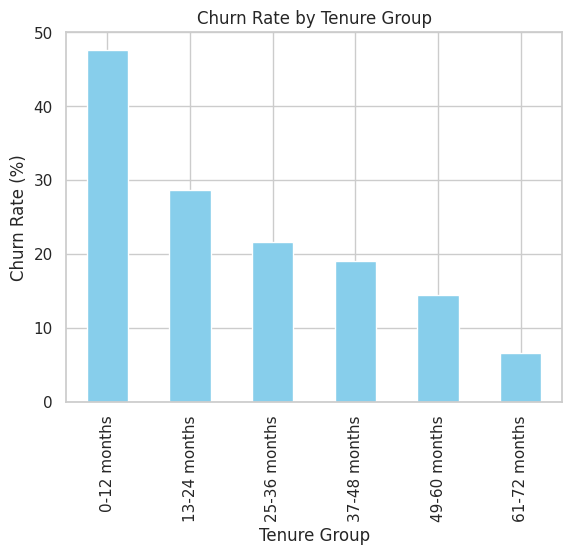

In [84]:
# 15. Churn Rate by Tenure Groups
# Create tenure groups
df['Tenure Group'] = pd.cut(df['Tenure Months'],
                            bins=[0, 12, 24, 36, 48, 60, 72],
                            labels=['0-12 months', '13-24 months', '25-36 months',
                                   '37-48 months', '49-60 months', '61-72 months'])
churn_rate_by_tenure = df.groupby('Tenure Group')['Churn Value'].mean() * 100
churn_rate_by_tenure.plot(kind='bar', color='skyblue')
plt.title('Churn Rate by Tenure Group')
plt.ylabel('Churn Rate (%)')
plt.show()

### Multivariate Analysis

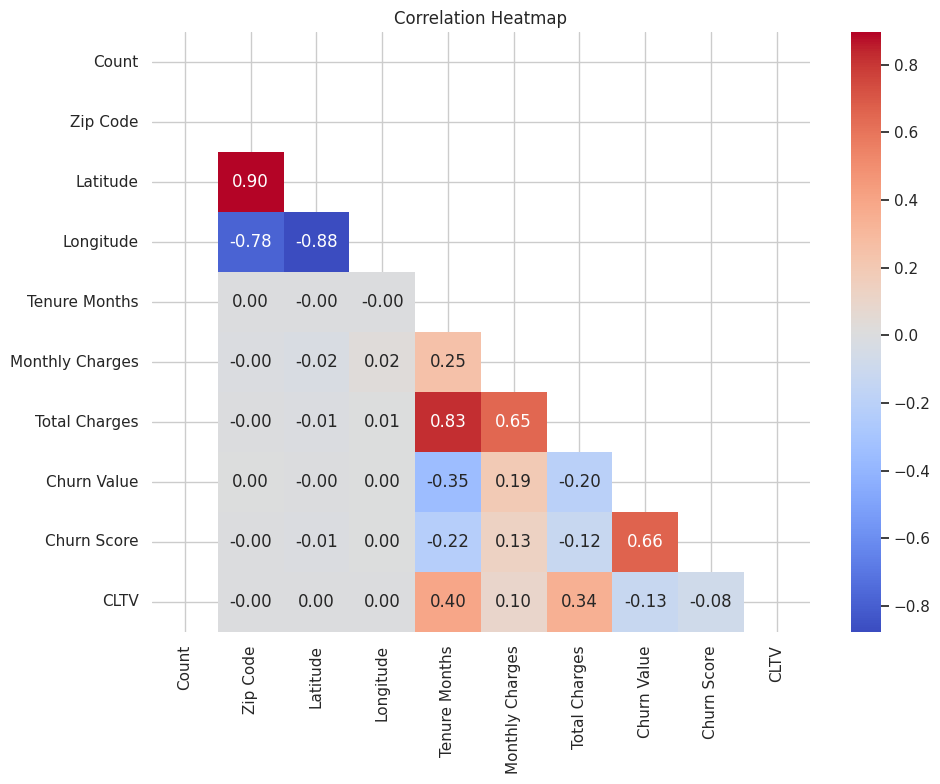

In [85]:
# 20. Correlation Heatmap of Numerical Features
plt.figure(figsize=(10, 8))
# Convert categorical to numeric for correlation analysis
df_numeric = df.select_dtypes(include=['number'])
correlation = df_numeric.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Count')

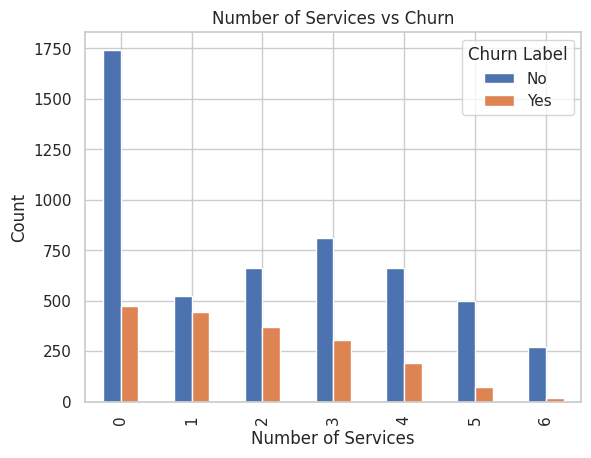

In [86]:
# 21. Services Analysis

# Calculate number of additional services for each customer
services = ['Online Security', 'Online Backup', 'Device Protection',
            'Tech Support', 'Streaming TV', 'Streaming Movies']

# Create a new column counting the number of services
df['Number of Services'] = df[services].apply(
    lambda row: sum(row.values == 'Yes'), axis=1)

# Plot number of services vs churn
service_churn = df.groupby(['Number of Services', 'Churn Label']).size().unstack()
service_churn.plot(kind='bar', stacked=False)
plt.title('Number of Services vs Churn')
plt.xlabel('Number of Services')
plt.ylabel('Count')



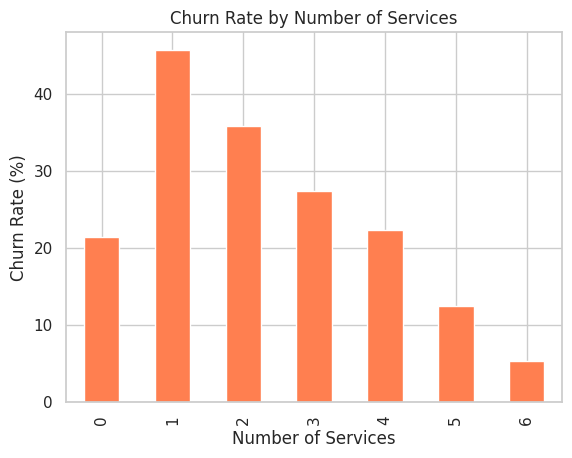

In [87]:
# Plot churn rate by number of services
churn_rate_by_services = df.groupby('Number of Services')['Churn Value'].mean() * 100
churn_rate_by_services.plot(kind='bar', color='coral')
plt.title('Churn Rate by Number of Services')
plt.xlabel('Number of Services')
plt.ylabel('Churn Rate (%)')
plt.show()

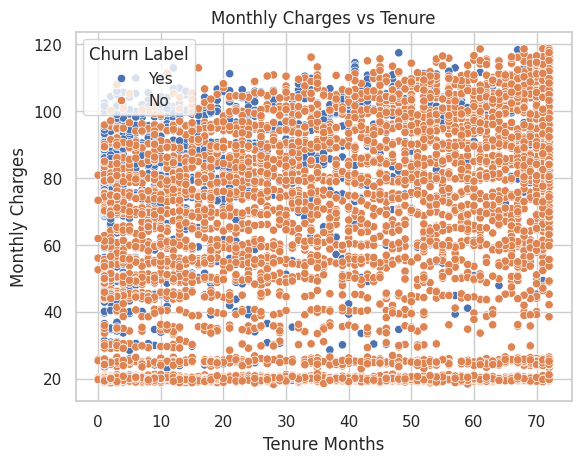

In [88]:
# 22. Monthly Charges vs Tenure with Churn indicated
sns.scatterplot(x='Tenure Months', y='Monthly Charges', hue='Churn Label', data=df)
plt.title('Monthly Charges vs Tenure')
plt.show()

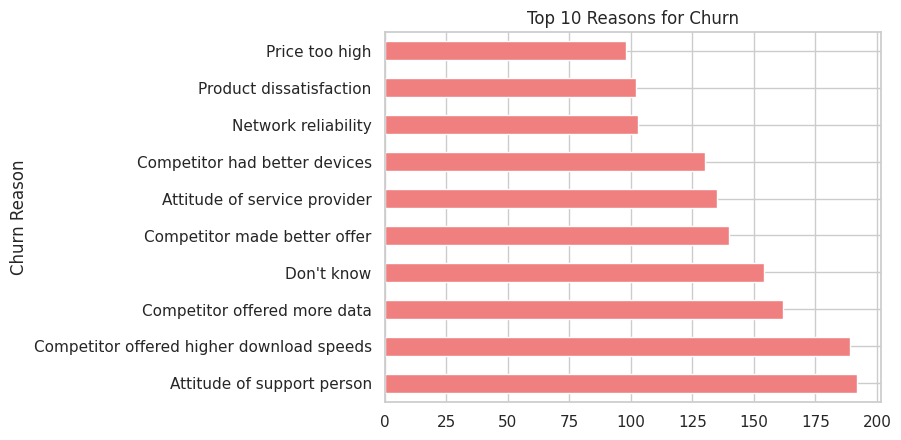

In [89]:
# 23. Churn Reasons Analysis (for churned customers)
churned_df = df[df['Churn Label'] == 'Yes']
top_reasons = churned_df['Churn Reason'].value_counts().head(10)
top_reasons.plot(kind='barh', color='lightcoral')
plt.title('Top 10 Reasons for Churn')
plt.show()

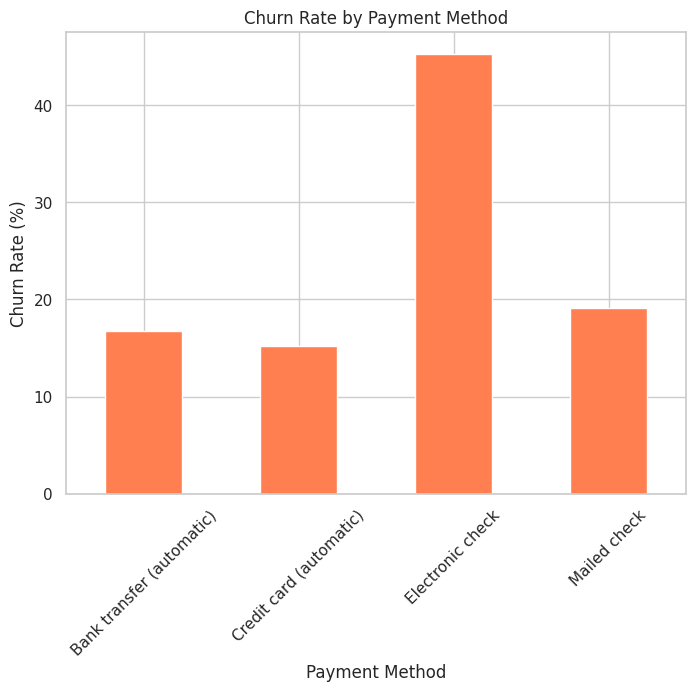

In [90]:
plt.figure(figsize=(8, 6))

# Calculate churn rate by payment method
payment_churn_rate = df.groupby('Payment Method')['Churn Value'].mean() * 100

# Plot bar chart
payment_churn_rate.plot(kind='bar', color='coral')
plt.title('Churn Rate by Payment Method')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Payment Method')
plt.xticks(rotation=45)
plt.show()


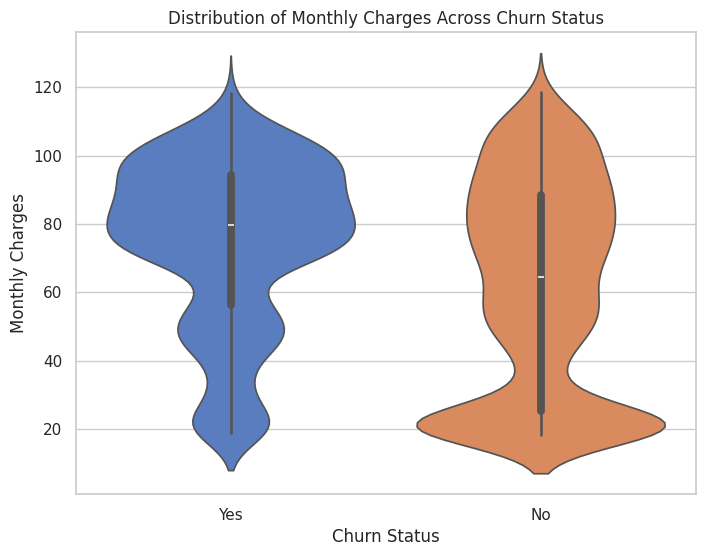

In [91]:
plt.figure(figsize=(8, 6))

sns.violinplot(x='Churn Label', y='Monthly Charges', data=df, palette='muted')
plt.title('Distribution of Monthly Charges Across Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Monthly Charges')
plt.show()


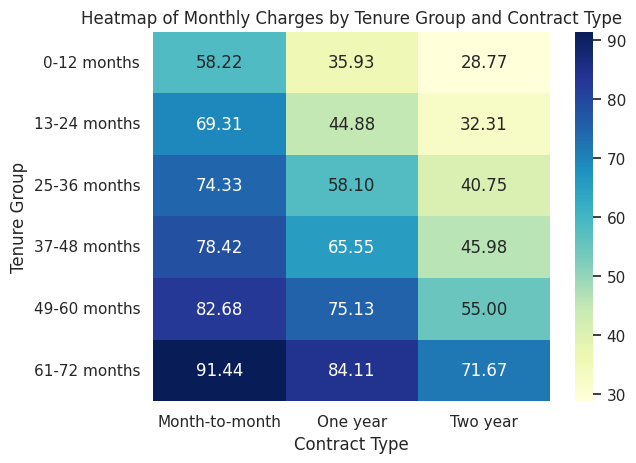

In [92]:
df['Tenure Group'] = pd.cut(df['Tenure Months'], bins=[0, 12, 24, 36, 48, 60, 72], labels=['0-12 months', '13-24 months', '25-36 months', '37-48 months', '49-60 months', '61-72 months'])

pivot_table = df.pivot_table(index='Tenure Group', columns='Contract', values='Monthly Charges', aggfunc='mean')

sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Heatmap of Monthly Charges by Tenure Group and Contract Type')
plt.ylabel('Tenure Group')
plt.xlabel('Contract Type')
plt.show()


## Feature Engineering and Preprocessing

In [93]:
# Import libraries for feature engineering
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pickle

# Define features for model building
# First, identify different types of columns
id_cols = ['CustomerID', 'Count']
geo_cols = ['Country', 'State', 'City', 'Zip Code', 'Latitude', 'Longitude', 'Lat Long']

# Target column
target = 'Churn Value'

# Columns to drop that aren't useful for prediction or contain data leakage
drop_cols = id_cols + geo_cols + ['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason']

# Select features for modeling
X = df.drop(drop_cols + [target], axis=1)
y = df[target]

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Further split categorical features into binary and multi-value
binary_features = [col for col in categorical_features
                   if X[col].nunique() == 2]
multi_features = [col for col in categorical_features
                  if X[col].nunique() > 2]

print("Numeric features:", numeric_features)
print("Binary categorical features:", binary_features)
print("Multi-value categorical features:", multi_features)


Numeric features: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Number of Services']
Binary categorical features: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
Multi-value categorical features: ['Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']


### New Features

In [94]:
# Feature Engineering

# 1. Create tenure groups
X['Tenure Group'] = pd.cut(X['Tenure Months'],
                          bins=[0, 12, 24, 36, 48, 60, 72],
                          labels=['0-12 months', '13-24 months', '25-36 months',
                                 '37-48 months', '49-60 months', '61-72 months'])

# 2. Calculate service count (number of additional services)
services = ['Online Security', 'Online Backup', 'Device Protection',
            'Tech Support', 'Streaming TV', 'Streaming Movies']
X['Service Count'] = X[services].apply(
    lambda row: sum(row.values == 'Yes'), axis=1)

# 3. Calculate monthly spending per service
X['Monthly Per Service'] = X['Monthly Charges'] / (X['Service Count'] + 1)  # +1 to avoid division by zero

# 4. Customer segmentation - create new household type feature
conditions = [
    (X['Senior Citizen'] == 1) & (X['Partner'] == 'Yes') & (X['Dependents'] == 'Yes'),
    (X['Senior Citizen'] == 1) & (X['Partner'] == 'Yes') & (X['Dependents'] == 'No'),
    (X['Senior Citizen'] == 1) & (X['Partner'] == 'No'),
    (X['Senior Citizen'] == 0) & (X['Partner'] == 'Yes') & (X['Dependents'] == 'Yes'),
    (X['Senior Citizen'] == 0) & (X['Partner'] == 'Yes') & (X['Dependents'] == 'No'),
    (X['Senior Citizen'] == 0) & (X['Partner'] == 'No')
]
choices = ['Senior Family', 'Senior Couple', 'Senior Single',
           'Family', 'Couple', 'Single']
X['Household Type'] = np.select(conditions, choices, default='Unknown')

# 5. Payment reliability indicator
electronic_payment = (X['Payment Method'] == 'Electronic check') | (X['Payment Method'] == 'Bank transfer (automatic)') | (X['Payment Method'] == 'Credit card (automatic)')
X['Electronic Payment'] = electronic_payment.astype(int)

# Update feature lists after engineering
# Update numeric features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Update categorical features after engineering
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# Further split categorical features
binary_features = [col for col in categorical_features if X[col].nunique() == 2]
multi_features = [col for col in categorical_features if X[col].nunique() > 2]


### Preprocessing Pipeline

In [95]:
# Create preprocessing pipeline with ColumnTransformer

# Preprocessing for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for binary categorical features
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# Preprocessing for multi-value categorical features
multi_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, binary_features),
        ('multi', multi_transformer, multi_features)
    ])

# Create feature names for the transformed data
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    feature_names = []

    # Handle numeric features (no transformation of feature names)
    feature_names.extend(numeric_features)

    # Handle binary features (no transformation of feature names)
    feature_names.extend(binary_features)

    # Handle multi-value features (need to get OneHotEncoder feature names)
    ohe_feature_names = []
    for i, feature in enumerate(multi_features):
        categories = X[feature].unique()
        # Skip the first category as it's dropped in OneHotEncoder(drop='first')
        for category in categories[1:]:
            ohe_feature_names.append(f"{feature}_{category}")

    feature_names.extend(ohe_feature_names)

    return feature_names

# Fit the preprocessor to get the transformed features
X_preprocessed = preprocessor.fit_transform(X)

# Get feature names after transformation
feature_names_after_transform = get_feature_names(preprocessor)
print(f"Number of features after transformation: {X_preprocessed.shape[1]}")
print(f"First 10 feature names: {feature_names_after_transform[:10]}")

# Save the preprocessor for later use
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)


Number of features after transformation: 34
First 10 feature names: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Number of Services', 'Service Count', 'Monthly Per Service', 'Electronic Payment', 'Gender', 'Senior Citizen', 'Partner']


## Model Training and Hyperparameter Tuning

In [96]:
# Import necessary libraries for modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import xgboost as xgb
import time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (5634, 34)
Testing set shape: (1409, 34)


### Model Training Function

In [97]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, params, X_train, X_test, y_train, y_test, model_name):
    print(f"\n----- Training {model_name} -----")

    # Track training time
    start_time = time.time()

    # Train with GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    # Fit the model
    grid_search.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Get the best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print results
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Training time: {training_time:.2f} seconds")

    # Save the model
    with open(f'{model_name}_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)

    # Store results for comparison
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'training_time': training_time,
        'best_params': grid_search.best_params_,
        'model': best_model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    return results


### Logistic Regression - Training

In [98]:
# 1. Train Logistic Regression
log_reg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'max_iter': [100, 200, 500]
}

log_reg_model = LogisticRegression(random_state=42)
log_reg_results = train_and_evaluate_model(
    log_reg_model, log_reg_params, X_train, X_test,
    y_train, y_test, 'logistic_regression')


----- Training logistic_regression -----
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.8034
Precision: 0.6804
Recall: 0.5800
F1 Score: 0.6262
ROC AUC: 0.8540
Training time: 8.68 seconds


### Decision Tree - Training

In [99]:
# 2. Train Decision Tree
dt_params = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_model = DecisionTreeClassifier(random_state=42)
dt_results = train_and_evaluate_model(
    dt_model, dt_params, X_train, X_test,
    y_train, y_test, 'decision_tree')


----- Training decision_tree -----
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy: 0.7814
Precision: 0.6402
Recall: 0.5250
F1 Score: 0.5769
ROC AUC: 0.8403
Training time: 14.77 seconds


### XGBoost - Training

In [100]:
# 3. Train XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_results = train_and_evaluate_model(
    xgb_model, xgb_params, X_train, X_test,
    y_train, y_test, 'xgboost')


----- Training xgboost -----
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.8070
Precision: 0.7038
Recall: 0.5525
F1 Score: 0.6190
ROC AUC: 0.8570
Training time: 87.04 seconds


### Storing training results

In [101]:
# Store all results for comparison
model_results = [log_reg_results, dt_results, xgb_results]

# Create a comparison dataframe
comparison_data = {
    'Model': [result['model_name'] for result in model_results],
    'Accuracy': [result['accuracy'] for result in model_results],
    'Precision': [result['precision'] for result in model_results],
    'Recall': [result['recall'] for result in model_results],
    'F1 Score': [result['f1'] for result in model_results],
    'ROC AUC': [result['roc_auc'] for result in model_results],
    'Training Time (s)': [result['training_time'] for result in model_results]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df.sort_values('ROC AUC', ascending=False)


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time (s)
2,xgboost,0.806955,0.703822,0.5525,0.619048,0.857004,87.036186
0,logistic_regression,0.803407,0.680352,0.5800,0.626181,0.854045,8.681893
1,decision_tree,0.781405,0.640244,0.5250,0.576923,0.840279,14.772032


## Performance Metrics Evaluation

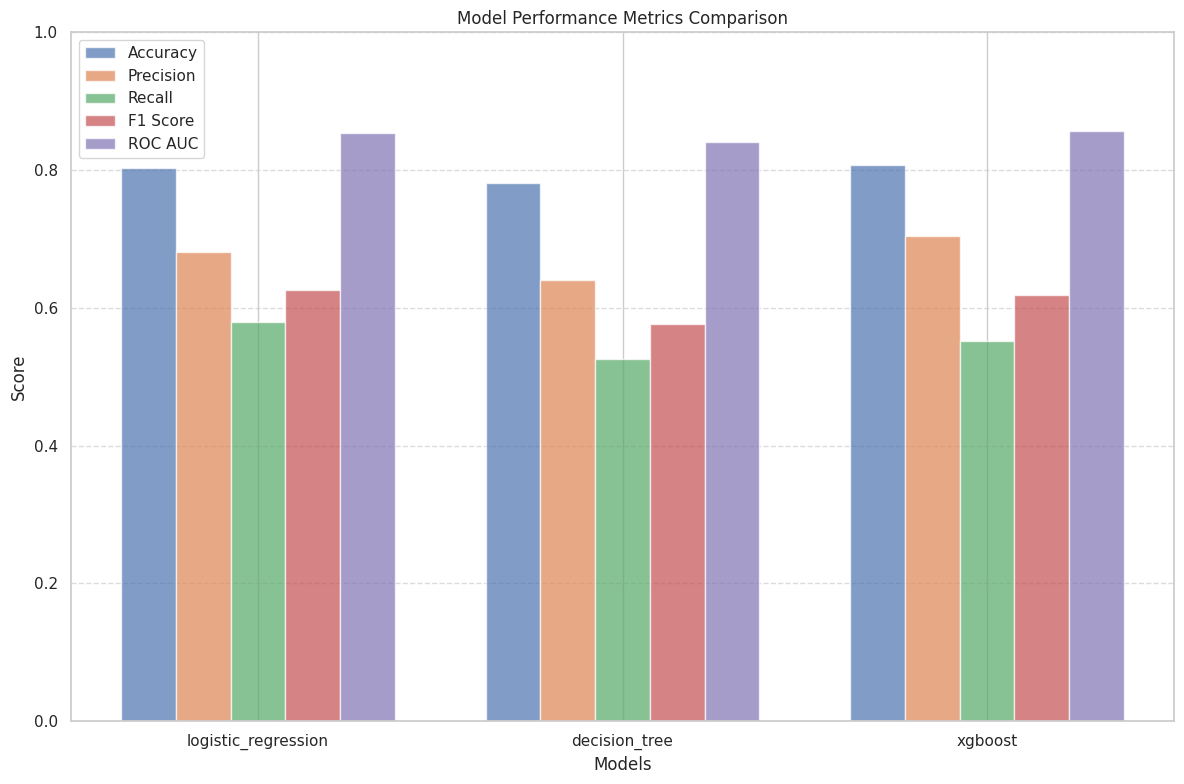

In [102]:
# Performance Metrics Visualization

# 1. Create a grouped bar chart to compare all metrics
plt.figure(figsize=(12, 8))
models = comparison_df['Model']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

bar_width = 0.15
index = np.arange(len(models))

for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, comparison_df[metric], bar_width,
            label=metric, alpha=0.7)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Metrics Comparison')
plt.xticks(index + bar_width * 2, models)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


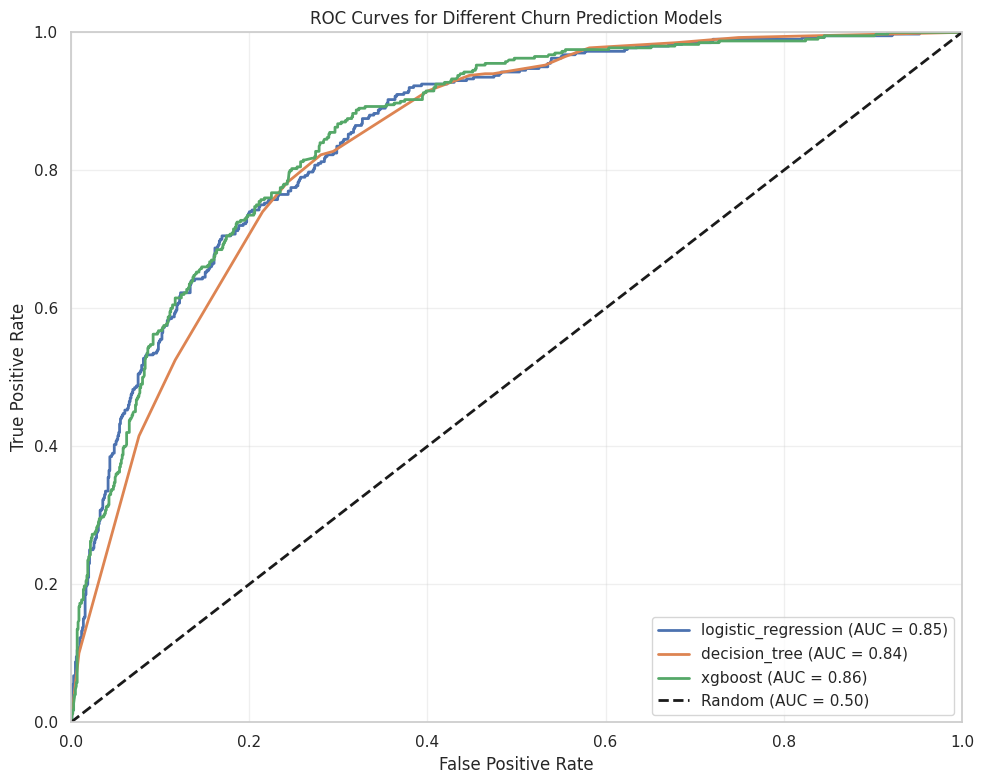

In [103]:
# 2. ROC Curve Comparison
plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
for result in model_results:
    model_name = result['model_name']
    y_pred_proba = result['y_pred_proba']

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2,
             label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Churn Prediction Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


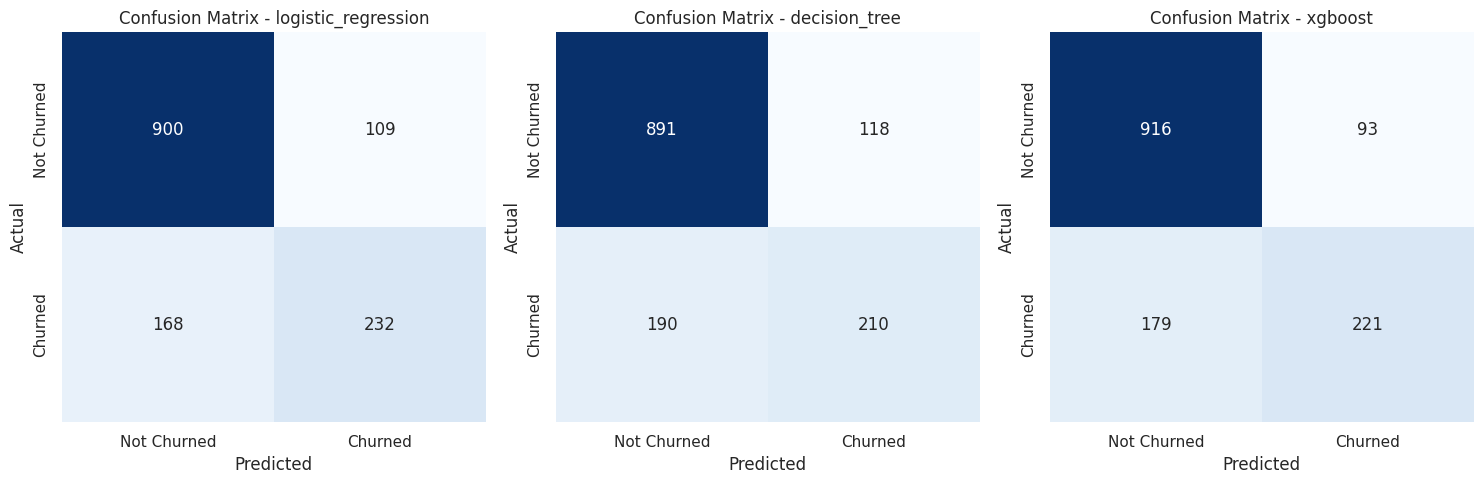

In [104]:
# 3. Confusion Matrix Visualization
import matplotlib.gridspec as gridspec

plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

for i, result in enumerate(model_results):
    model_name = result['model_name']
    y_pred = result['y_pred']

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    ax = plt.subplot(gs[i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xticklabels(['Not Churned', 'Churned'])
    ax.set_yticklabels(['Not Churned', 'Churned'])

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()


## Feature Importance Analysis

### Logistic Regression

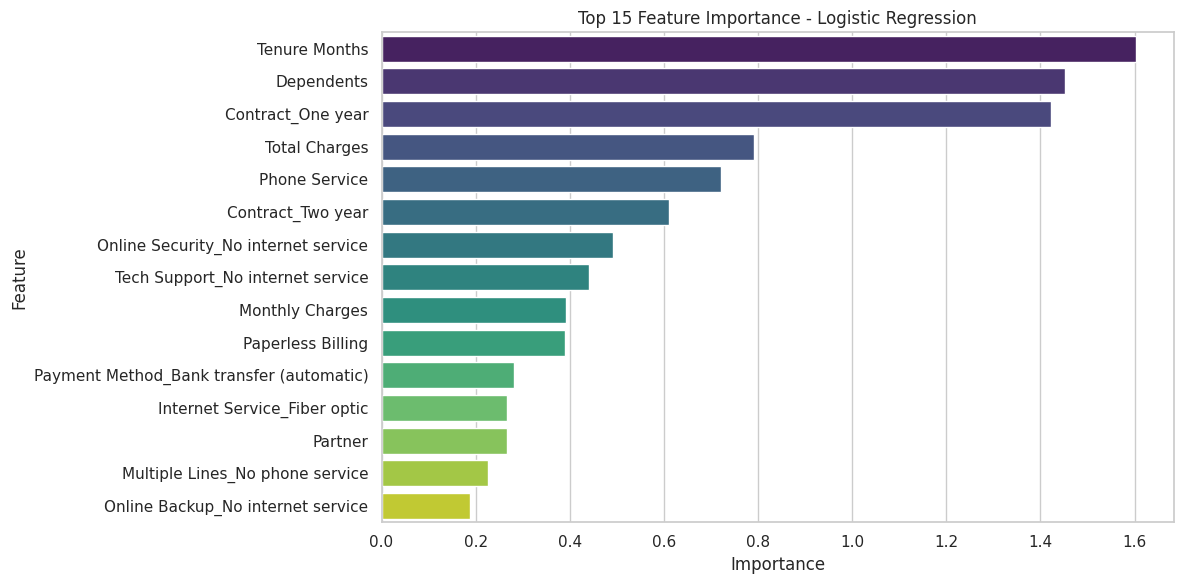

In [105]:
# Feature Importance Analysis for all models

# Get feature names
feature_names = get_feature_names(preprocessor)

# 1. Create feature importance visualization for Logistic Regression
plt.figure(figsize=(12, 6))

# Get the coefficients from the logistic regression model
log_reg_model = log_reg_results['model']
coefficients = log_reg_model.coef_[0]

# Create a DataFrame with feature names and coefficients
log_reg_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)  # Use absolute values for importance
})

# Sort by importance and get top 15
log_reg_importance = log_reg_importance.sort_values('Importance', ascending=False).head(15)

# Create the bar plot
sns.barplot(x='Importance', y='Feature', data=log_reg_importance, palette='viridis')
plt.title('Top 15 Feature Importance - Logistic Regression')
plt.tight_layout()
plt.savefig('logistic_regression_importance.png')
plt.show()


### Decision Tree

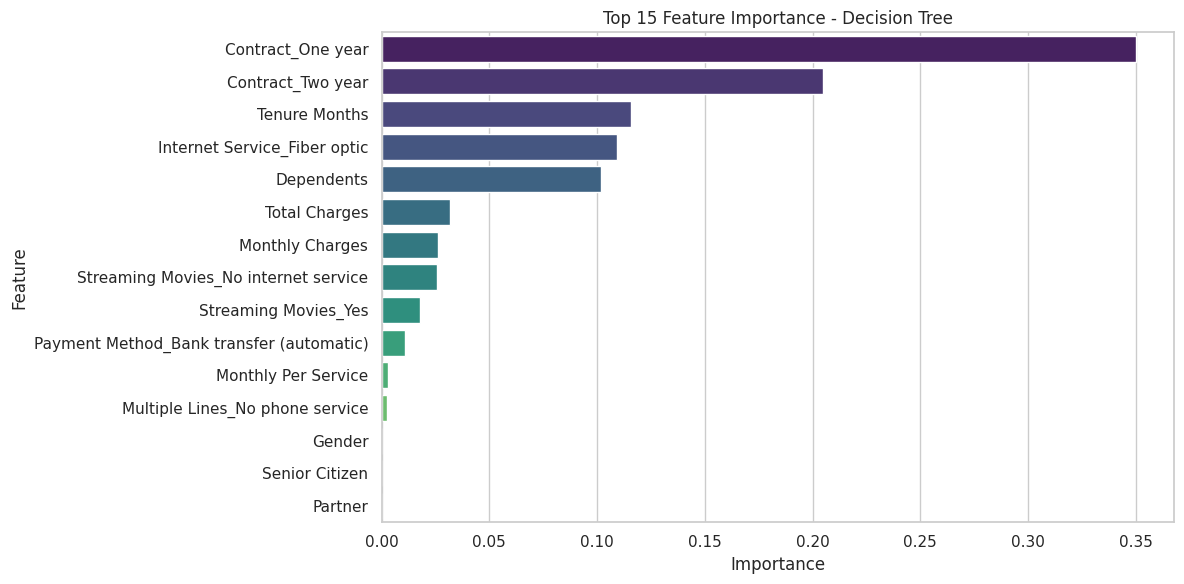

In [106]:
# 2. Feature importance for Decision Tree
plt.figure(figsize=(12, 6))

# Get the feature importances from the decision tree model
dt_model = dt_results['model']
dt_importances = dt_model.feature_importances_

# Create a DataFrame with feature names and importances
dt_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_importances
})

# Sort by importance and get top 15
dt_importance = dt_importance.sort_values('Importance', ascending=False).head(15)

# Create the bar plot
sns.barplot(x='Importance', y='Feature', data=dt_importance, palette='viridis')
plt.title('Top 15 Feature Importance - Decision Tree')
plt.tight_layout()
plt.savefig('decision_tree_importance.png')
plt.show()


### XGBoost

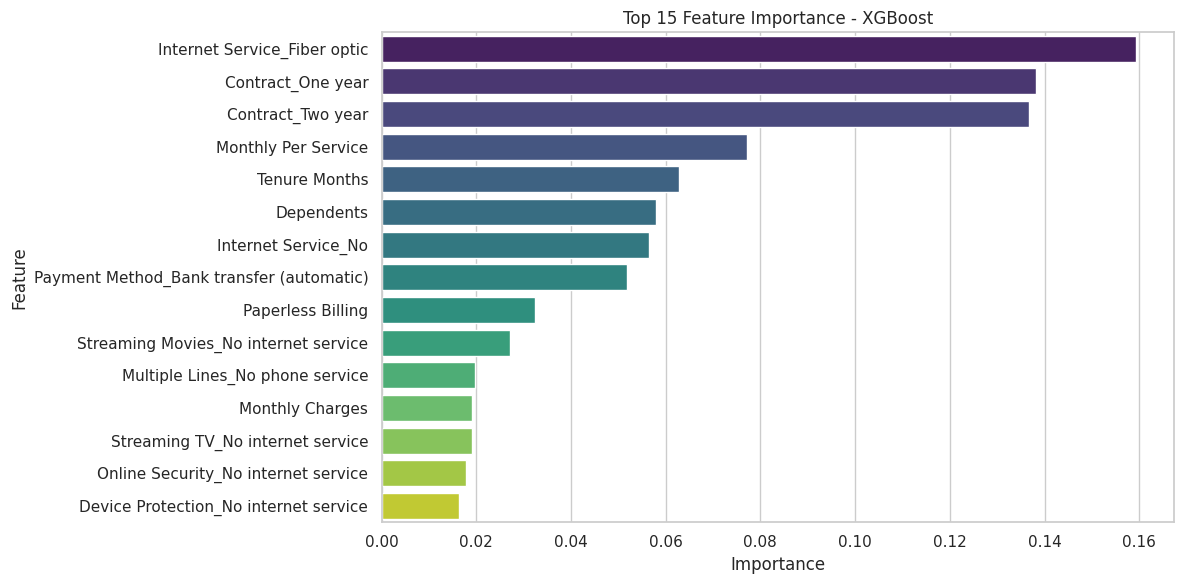

In [107]:
# 3. Feature importance for XGBoost
plt.figure(figsize=(12, 6))

# Get the feature importances from the XGBoost model
xgb_model = xgb_results['model']
xgb_importances = xgb_model.feature_importances_

# Create a DataFrame with feature names and importances
xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
})

# Sort by importance and get top 15
xgb_importance = xgb_importance.sort_values('Importance', ascending=False).head(15)

# Create the bar plot
sns.barplot(x='Importance', y='Feature', data=xgb_importance, palette='viridis')
plt.title('Top 15 Feature Importance - XGBoost')
plt.tight_layout()
plt.savefig('xgboost_importance.png')
plt.show()


### Combined

In [108]:
# 4. Combined Feature Importance Analysis
# Get Top 10 features from each model
top_features_lr = log_reg_importance.head(10)['Feature'].tolist()
top_features_dt = dt_importance.head(10)['Feature'].tolist()
top_features_xgb = xgb_importance.head(10)['Feature'].tolist()

# Find common important features across models
common_features = list(set(top_features_lr) & set(top_features_dt) & set(top_features_xgb))

# Create a list of all unique top features
all_top_features = list(set(top_features_lr + top_features_dt + top_features_xgb))

# Create a DataFrame to display importance across all models
combined_importance = pd.DataFrame({
    'Feature': all_top_features
})

# Add importance for each model
combined_importance['LR_Importance'] = combined_importance['Feature'].map(
    log_reg_importance.set_index('Feature')['Importance'])
combined_importance['DT_Importance'] = combined_importance['Feature'].map(
    dt_importance.set_index('Feature')['Importance'])
combined_importance['XGB_Importance'] = combined_importance['Feature'].map(
    xgb_importance.set_index('Feature')['Importance'])

# Fill NaN values with 0 (features not in top 10 for a model)
combined_importance = combined_importance.fillna(0)

# Calculate average importance across models and sort
combined_importance['Avg_Importance'] = combined_importance[
    ['LR_Importance', 'DT_Importance', 'XGB_Importance']].mean(axis=1)
combined_importance = combined_importance.sort_values('Avg_Importance', ascending=False)

print("Top 10 Most Important Features Across All Models:")
combined_importance.head(10)


Top 10 Most Important Features Across All Models:


,Feature,LR_Importance,DT_Importance,XGB_Importance,Avg_Importance
15,Contract_One year,1.422048,0.350207,0.138148,0.636801
13,Tenure Months,1.603718,0.115984,0.062732,0.594144
3,Dependents,1.451573,0.101677,0.057930,0.537060
1,Contract_Two year,0.611785,0.204766,0.136770,0.317774
14,Total Charges,0.790939,0.031656,0.000000,0.274198
12,Phone Service,0.722278,0.000000,0.000000,0.240759
9,Internet Service_Fiber optic,0.267213,0.109091,0.159375,0.178560
2,Online Security_No internet service,0.492374,0.000000,0.017743,0.170039
5,Tech Support_No internet service,0.441632,0.000000,0.000000,0.147211
8,Monthly Charges,0.392604,0.026226,0.019110,0.145980


### Heatmap

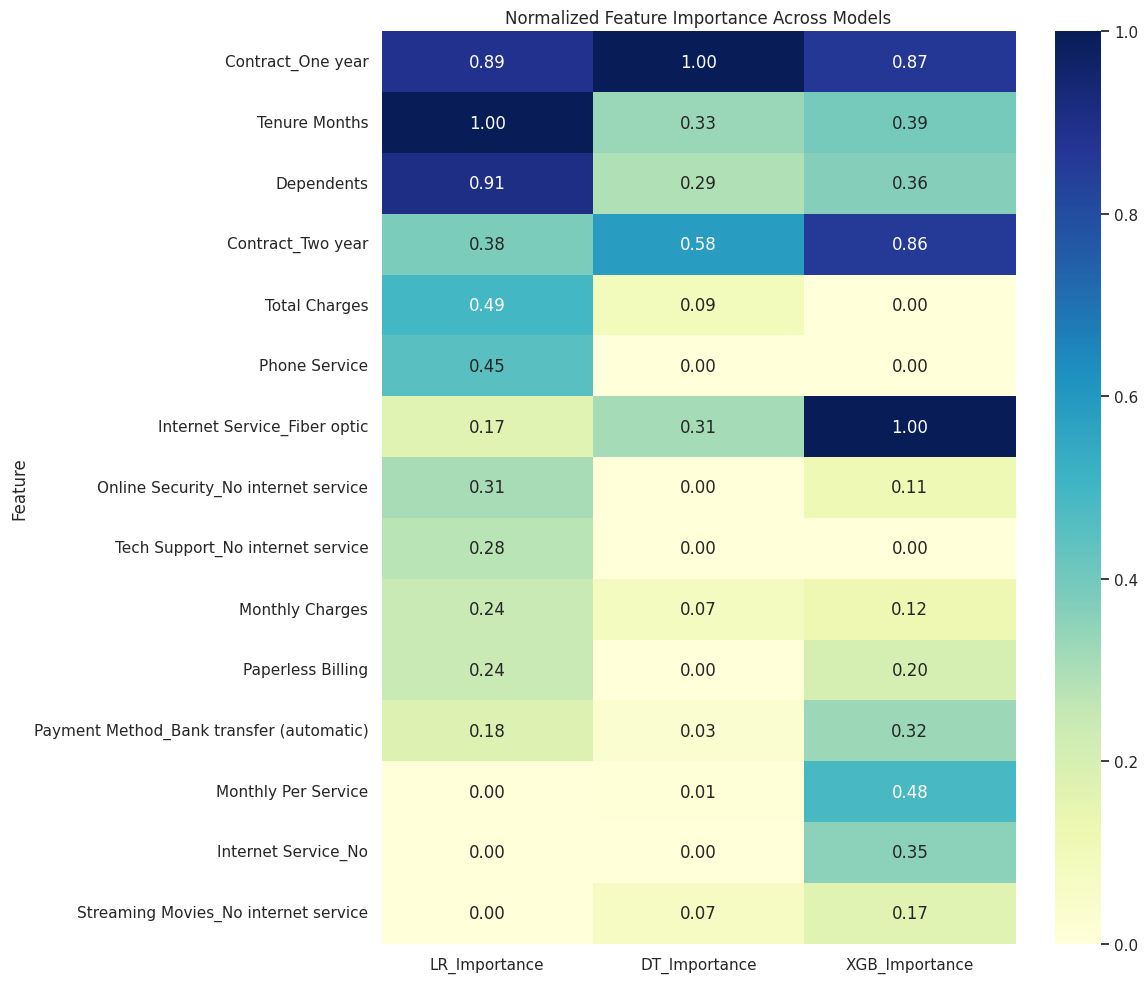

In [109]:
# 5. Feature Importance Heatmap
plt.figure(figsize=(12, 10))

# Prepare data for heatmap - top 15 features by average importance
heatmap_data = combined_importance.head(15).copy()

# Normalize importances for each model to [0, 1] scale
for col in ['LR_Importance', 'DT_Importance', 'XGB_Importance']:
    if heatmap_data[col].max() > 0:  # Avoid division by zero
        heatmap_data[col] = heatmap_data[col] / heatmap_data[col].max()

# Reshape data for heatmap
heatmap_pivot = heatmap_data.set_index('Feature')[
    ['LR_Importance', 'DT_Importance', 'XGB_Importance']]

# Create heatmap
sns.heatmap(heatmap_pivot, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Normalized Feature Importance Across Models')
plt.tight_layout()
plt.savefig('feature_importance_heatmap.png')
plt.show()


## Model Comparison

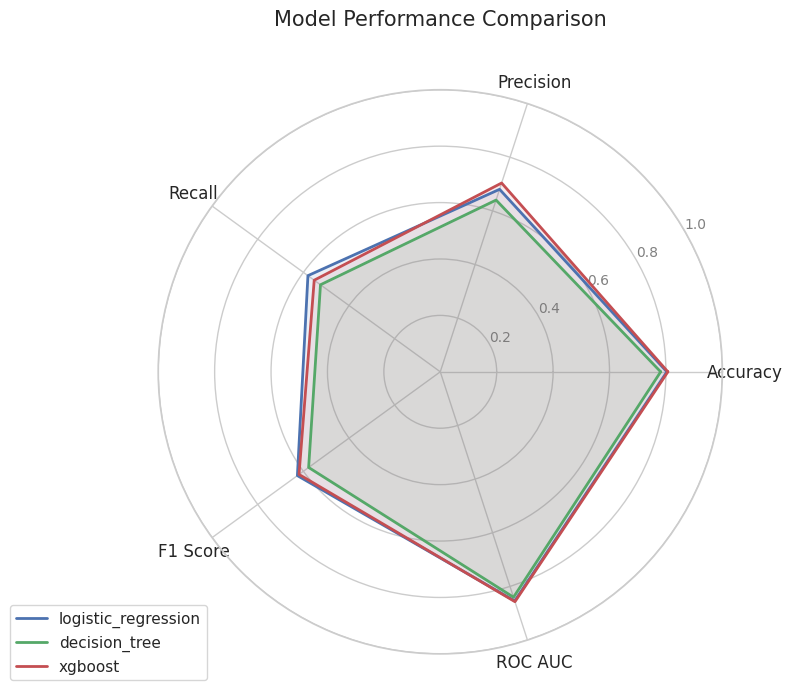

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def radar_plot(df, metrics):
    N = len(metrics)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    plt.xticks(angles[:-1], metrics, size=12)
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
    plt.ylim(0, 1)

    colors = ['b', 'g', 'r']

    for i, model in enumerate(df['Model']):
        values = df.loc[df['Model'] == model, metrics].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Model Performance Comparison', size=15, y=1.1)
    plt.tight_layout()
    plt.savefig('radar_chart_comparison.png')
    plt.show()

radar_plot(comparison_df, ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])


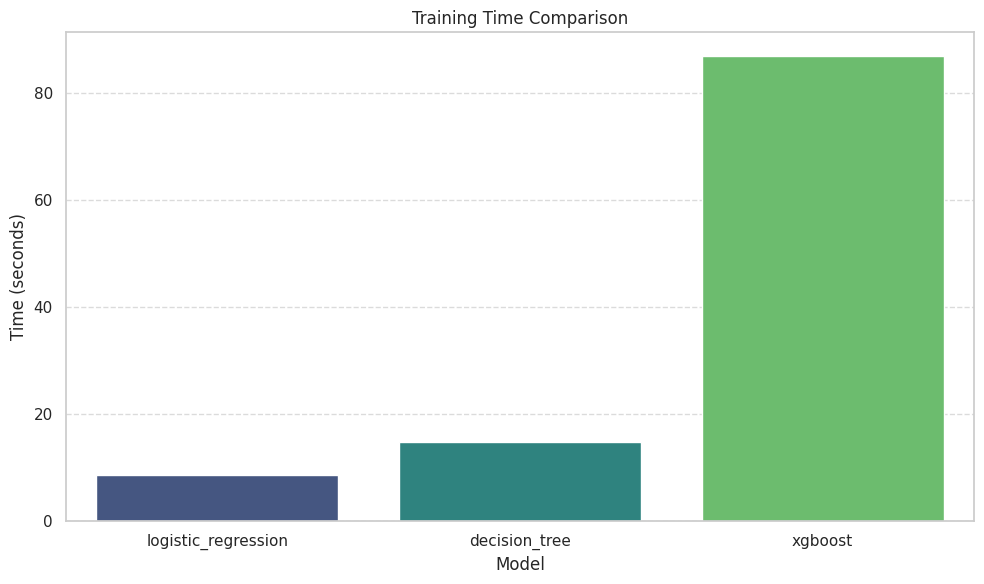

In [111]:
# 2. Training Time Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Training Time (s)', data=comparison_df, palette='viridis')
plt.title('Training Time Comparison')
plt.xticks(rotation=0)
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('training_time_comparison.png')
plt.show()


In [112]:
# 3. Model Ranking Table
# Function to rank models by each metric
def rank_models(df, metrics):
    ranked_df = df.copy()

    # Rank each metric (higher is better)
    for metric in metrics:
        ranked_df[f'{metric} Rank'] = ranked_df[metric].rank(ascending=False)

    # Calculate average rank
    rank_columns = [f'{metric} Rank' for metric in metrics]
    ranked_df['Average Rank'] = ranked_df[rank_columns].mean(axis=1)

    # Sort by average rank
    ranked_df = ranked_df.sort_values('Average Rank')

    return ranked_df

# Create ranking table
ranking_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
ranked_models = rank_models(comparison_df, ranking_metrics)

# Display ranking table
print("Model Ranking (1 is best):")
display_cols = ['Model'] + [f'{metric} Rank' for metric in ranking_metrics] + ['Average Rank']
ranked_models[display_cols]


Model Ranking (1 is best):


,Model,Accuracy Rank,Precision Rank,Recall Rank,F1 Score Rank,ROC AUC Rank,Average Rank
2,xgboost,1.0,1.0,2.0,2.0,1.0,1.4
0,logistic_regression,2.0,2.0,1.0,1.0,2.0,1.6
1,decision_tree,3.0,3.0,3.0,3.0,3.0,3.0


In [113]:
# 5. Final Model Selection and Conclusion
best_model_name = ranked_models.iloc[0]['Model']
best_model = next(result['model'] for result in model_results
                 if result['model_name'] == best_model_name)

print(f"\n----- Final Model Selection -----")
print(f"The best performing model is: {best_model_name}")
print(f"Average Rank: {ranked_models.iloc[0]['Average Rank']:.2f}")


----- Final Model Selection -----
The best performing model is: xgboost
Average Rank: 1.40
